# Machine Astrophysics

Introductory reading:
https://otherful.wordpress.com/2018/02/14/gozogon-an-introduction/

"The story takes place on the planet Gozogon, on an S-type orbit around Gnos in the Gnoslor binary system.
Except that the Gozogonians know very little about this because they have not discovered the physics of celestial objects, they don’t have a simple model of gravity.
They do however know, and can predict with precision, the location of any of the bodies they see in the sky, thanks to their supercomputer systems, interlinked across the planet wherever there is life.

In contrast to Earth, physics did not rise from the motion of celestial bodies...
... the first science to develop was not astronomy, it was biology (if we expand it to include what the Earthlings call psychology, sociology, etc). Gozogon did raise many genius scientists, only not in the directions that we had on Earth. The intricate relations between members of a species, and across species, was a more urgent matter and that was where the animals used their brains to figure out first. Going deeper, they discovered chemistry and eventually, physics of particles at smaller and smaller scales. They were able to manipulate what they learned from nature to invent and create new lifeforms, among which the distinguished entity called RedRoot rose."

This study explores the discovery potential of learning systems, how the data can be converted into formulas.

## Mars retrograde detection

The first case study is the retrograde motion of Mars from the perspective of Earth. This is a very simple system of two co-centric, almost circular, orbits where the external one appears to be moving backwards at certain times. 

Such a system was an important cornerstone in the history of astrophysics, that inspired Ptolemy for his epicycles to model the system, later to be replaced by a simpler model of Copernicus.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

### Generate system

We simulate a system of two planets, rotating around a motionless sun. The orbits will be chosen to be almost circular, the challenge mostly concentrating on the retrograde motion which suggests a concentric motion of the two planets.
We will simulate the motion in 'n_sim' time steps, and sample every 'n_view'th of those steps as an observation point.

In [2]:
n_sim = 1000
n_view = 10
s = gen.System()
s.force = s.force_gravity
s.generate(2)
s.simulate(n_sim)
s.view(0, n_view)

Adding body with spring length :  0.0
Adding body with spring length :  14.8660687473
Adding body with spring length :  5.0
Adding body with spring length :  141.421356237
Adding body with spring length :  247.491413992


### Visualise the system

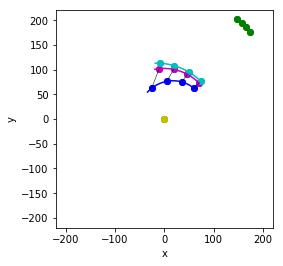

In [3]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-220,220])
ax.set_ylim([-220,220])
plt.axes().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')

# Plot only every 't_res'th point, up to t_max
t_res = 30
t_max = 800
plot_orbit(ax, s, 0)
plot_orbit(ax, s, 1)
plot_orbit(ax, s, 2)
plot_orbit(ax, s, 3)
plot_orbit(ax, s, 4)
plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)
plot_position(ax, s, 3, t_res, t_max)
plot_position(ax, s, 4, t_res, t_max)
#plot_observation(ax,s,0,-1,t_res)
plot_observation(ax,s,1,0,t_res, t_max)

plt.show()
plt.savefig("orbits.png")

### Observe the planet angle

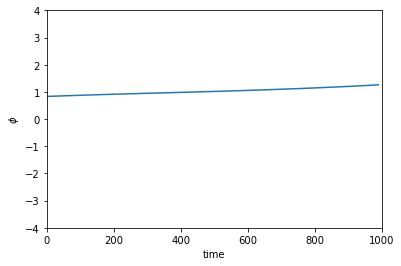

In [4]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')


phis = s.get_phi(1)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.show()
plt.savefig("angle_of_mars.png")

### Fit with a Ptolemian Model

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Analytic description of epicycles with radius a and rotation speed w at time t
# t must not be an array

def f_x(a, w, p, t):
    return np.sum(a * np.cos(w * t + p))

def f_y(a, w, p, t):
    return np.sum(a * np.sin(w * t + p))

def f_phi(a, w, p, t):
    return np.arctan2(f_y(a, w, p, t), f_x(a, w, p, t))

In [7]:
#a = np.array([5., 3., 0.5])
#w = np.array([0.5, 2., 7.])
#p = np.array([0., 0., 0.])
#phi = [f_phi(a, w, p, i) for i in t]
#plt.plot(t, phi)
#plt.show()

In [8]:
from scipy.optimize import minimize

In [9]:
def epicycle_error(c):
    a = c[0::3]
    w = c[1::3]
    p = c[2::3]
    phi_epi = [f_phi(a, w, p, i) for i in t]
    return np.sum((np.unwrap(phis - phi_epi))**2)

In [10]:
c0 = np.array([74., 0.0014, 0., 87.,  0.0010, 0.])
a_bnds = (70., 100.)
w_bnds = (0.0007, 0.0016)
p_bnds = (0., np.pi/2.)
bnds = (a_bnds, w_bnds, p_bnds, a_bnds,  w_bnds, p_bnds)
res = minimize(fun=epicycle_error, x0=c0,
               method='Nelder-Mead', tol=1e-8,
               bounds=bnds,
               options={'xtol': 0.001, 'eps': 0.02, 'maxiter': 100000})

/anaconda/envs/python36/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:9: OptimizeWarning: Unknown solver options: eps
  if __name__ == '__main__':


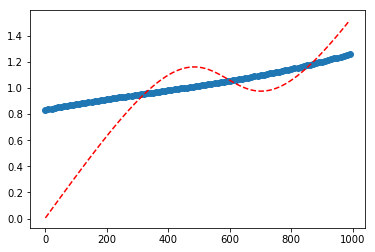

In [11]:
c = res.x    
a = c[0::3]
w = c[1::3]
p = c[2::3]
phi_epi = [f_phi(a, w, p, i) for i in t]
plt.scatter(t, phis)
plt.plot(t, phi_epi, color='r', linestyle='dashed')
plt.savefig("ptolemian_mars.png")
plt.show()

In [12]:
res.x

array([  1.66933434e-09,   7.10557679e-03,  -3.44250445e-05,
         4.48079719e-09,   1.79133767e-03,   7.36498726e-03])

In [13]:
res

 final_simplex: (array([[  1.66933434e-09,   7.10557679e-03,  -3.44250445e-05,
          4.48079719e-09,   1.79133767e-03,   7.36498726e-03],
       [  3.23998893e-09,   7.10557627e-03,  -3.44254173e-05,
          8.69671964e-09,   1.79133752e-03,   7.36498703e-03],
       [  1.89718279e-09,   7.10557629e-03,  -3.44254036e-05,
          5.09238203e-09,   1.79133752e-03,   7.36498703e-03],
       [  3.32534210e-09,   7.10557631e-03,  -3.44253991e-05,
          8.92582885e-09,   1.79133753e-03,   7.36498705e-03],
       [  4.10253743e-09,   7.10557656e-03,  -3.44252201e-05,
          1.10119615e-08,   1.79133760e-03,   7.36498716e-03],
       [  4.39583126e-09,   7.10557650e-03,  -3.44252660e-05,
          1.17992145e-08,   1.79133758e-03,   7.36498713e-03],
       [  1.94163484e-09,   7.10557648e-03,  -3.44252552e-05,
          5.21170811e-09,   1.79133758e-03,   7.36498712e-03]]), array([ 8.08021605,  8.08021605,  8.08021605,  8.08021605,  8.08021605,
        8.08021605,  8.08021605]))

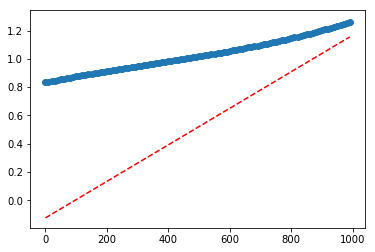

In [14]:
# fit by hand
c = np.array( [21,   0.00153,  -0.3, 27,   0.00111,   0.01])
a = c[0::3]
w = c[1::3]
p = c[2::3]
phi_epi = [f_phi(a, w, p, i) for i in t]
plt.scatter(t, phis)
plt.plot(t, phi_epi, color='r', linestyle='dashed')
plt.show()

In [15]:
p

array([-0.3 ,  0.01])

### Predict the planet angle from time series 

In [43]:
n = 5
phis = s.get_phi(1)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)

from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(n,), dtype='float', name='main_input')
layer = Dense(60, activation='relu', kernel_initializer='normal')(inputs)
layer = Dense(15, activation='relu', kernel_initializer='normal')(layer)
predictions = Dense(1, kernel_initializer='normal')(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y, epochs=5, batch_size=1, verbose=2)

In [45]:
y_pred = model.predict(x)*np.pi
y_true = y*np.pi

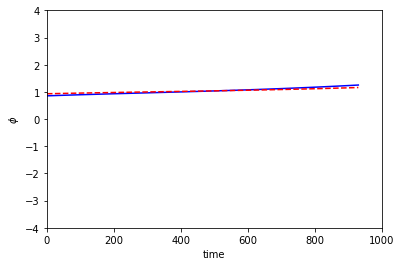

In [47]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("predicted_mars.png")
plt.show()

In [103]:
print([i for i in range(5)])

[0, 1, 2, 3, 4]


### LSTM example

In [147]:
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [148]:
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(s.get_phi(1).reshape(-1, 1))

In [149]:
def create_dataset(dataset, look_back=1):
    x, y = np.ndarray(shape=(0, look_back, 1)), np.array([])
    length = len(dataset) - look_back - 1
    for i in range(length):
        a = dataset[i:(i + look_back)].reshape(-1, look_back, 1)
        x = np.concatenate((x, a), axis=0)
        y = np.concatenate((y, [dataset[i + look_back, 0]]), axis=0)
#    x = np.reshape(x, (x.shape[0], look_back, x.shape[1]))
    return x, y

# reshape input to be [samples, time steps, features]

test = s.get_phi(1).reshape(-1, 1) / np.pi
x, y = create_dataset(test, n)
#x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

In [150]:
x.shape

(94, 5, 1)

In [151]:
x.shape[0]

94

In [152]:
len(y)

94

In [153]:
94*5

470

In [155]:
# create and fit the LSTM network
#model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(x, y, epochs=5, batch_size=1, verbose=2)

inputs = Input(shape=(n, 1), dtype='float', name='main_input')
#inputs = Input(shape=(1, n), dtype='float', name='main_input')
# why not (n, 1) ?
# CHECK THIS! FEATURES VS TIMESTEPS

layer = LSTM(4)(inputs)
predictions = Dense(1)(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
2s - loss: 0.0594
Epoch 2/5
1s - loss: 0.0021
Epoch 3/5
1s - loss: 8.1112e-04
Epoch 4/5
1s - loss: 8.1528e-04
Epoch 5/5
1s - loss: 7.8484e-04


In [156]:
n

5

In [157]:
y_pred = model.predict(x) * np.pi
y_true = y * np.pi

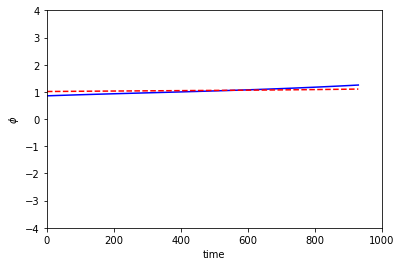

In [159]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("predicted_lstm.png")
plt.show()

### Look at another planet, with previous training

In [29]:
phis = s.get_phi(2).reshape(-1,1)
#series = make_time_series(phis, depth=n+1)
#y = series[:,n].reshape(-1,1)
#x = series[:,0:n].reshape(-1,n)
x, y = create_dataset(phis/np.pi, n)
#x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

y_pred = model.predict(x) * np.pi
y_true = y * np.pi

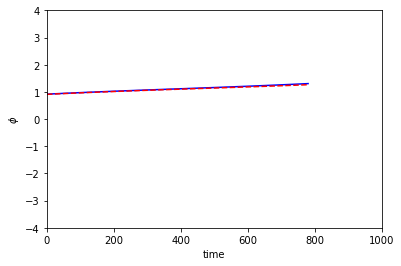

In [31]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("predicted_uranus.png")
plt.show()

### Fit this planet with Ptolemian model

In [32]:
c0 = np.array([74., 0.0014, 0., 87.,  0.001, 0., 20., 0.001, 0.])
a_bnds = (20., 100.)
w_bnds = (0.0001, 0.0016)
p_bnds = (0., np.pi/2.)
bnds = (a_bnds, w_bnds, p_bnds, a_bnds,  w_bnds, p_bnds, a_bnds,  w_bnds, p_bnds)
res = minimize(fun=epicycle_error, x0=c0,
               method='Nelder-Mead', tol=1e-8,
               bounds=bnds,
               options={'xtol': 0.001, 'eps': 0.2, 'maxiter': 100000})

/anaconda/envs/python36/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:9: OptimizeWarning: Unknown solver options: eps
  if __name__ == '__main__':


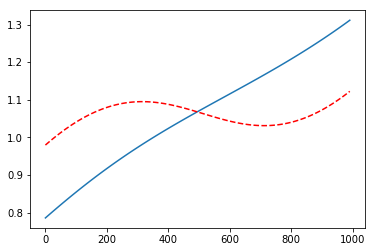

In [33]:
c = res.x    
a = c[0::3]
w = c[1::3]
p = c[2::3]
phi_epi = [f_phi(a, w, p, i) for i in t]
plt.plot(t, phis)
plt.plot(t, phi_epi, color='r', linestyle='dashed')
plt.show()
plt.savefig("ptolemian_uranus.png")

In [34]:
c0 = np.array([74., 0.0014, 0., 87.,  0.001, 0., 20., 0.001, 0.])
p = c0[0::1]

In [35]:
c

array([ -5.56923172e-11,   2.25153947e-03,   5.14001340e-03,
        -1.31191239e-08,   1.36143897e-03,   2.12847203e-03,
         1.32072486e-08,   1.36011649e-03,   5.77369756e-03])

### Repeat all with a much farther planet

In [73]:
phis = s.get_phi(3)/np.pi
series = make_time_series(phis, depth=n+1)
#y = series[:,n].reshape(-1,1)
#x = series[:,0:n].reshape(-1,n)
phis = s.get_phi(2).reshape(-1,1)
#series = make_time_series(phis, depth=n+1)
#y = series[:,n].reshape(-1,1)
#x = series[:,0:n].reshape(-1,n)
x, y = create_dataset(phis/np.pi, n)
#x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
y_pred = model.predict(x) * np.pi
y_true = y * np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("predicted_pluto.png")
plt.show()

ValueError: Error when checking : expected main_input to have 3 dimensions, but got array with shape (94, 5)

In [74]:
x

array([[ 0.2502273 ,  0.25249212,  0.25474157,  0.25697495,  0.25919162],
       [ 0.25249212,  0.25474157,  0.25697495,  0.25919162,  0.26139097],
       [ 0.25474157,  0.25697495,  0.25919162,  0.26139097,  0.26357243],
       [ 0.25697495,  0.25919162,  0.26139097,  0.26357243,  0.26573549],
       [ 0.25919162,  0.26139097,  0.26357243,  0.26573549,  0.26787967],
       [ 0.26139097,  0.26357243,  0.26573549,  0.26787967,  0.27000454],
       [ 0.26357243,  0.26573549,  0.26787967,  0.27000454,  0.27210972],
       [ 0.26573549,  0.26787967,  0.27000454,  0.27210972,  0.27419488],
       [ 0.26787967,  0.27000454,  0.27210972,  0.27419488,  0.27625971],
       [ 0.27000454,  0.27210972,  0.27419488,  0.27625971,  0.27830399],
       [ 0.27210972,  0.27419488,  0.27625971,  0.27830399,  0.28032751],
       [ 0.27419488,  0.27625971,  0.27830399,  0.28032751,  0.28233011],
       [ 0.27625971,  0.27830399,  0.28032751,  0.28233011,  0.2843117 ],
       [ 0.27830399,  0.28032751,  0.2

In [72]:
xx

array([[[ 0.2652901 ,  0.26671951,  0.26813118,  0.26952532,  0.27090216]],

       [[ 0.26671951,  0.26813118,  0.26952532,  0.27090216,  0.27226196]],

       [[ 0.26813118,  0.26952532,  0.27090216,  0.27226196,  0.27360502]],

       [[ 0.26952532,  0.27090216,  0.27226196,  0.27360502,  0.27493167]],

       [[ 0.27090216,  0.27226196,  0.27360502,  0.27493167,  0.27624225]],

       [[ 0.27226196,  0.27360502,  0.27493167,  0.27624225,  0.27753714]],

       [[ 0.27360502,  0.27493167,  0.27624225,  0.27753714,  0.27881675]],

       [[ 0.27493167,  0.27624225,  0.27753714,  0.27881675,  0.2800815 ]],

       [[ 0.27624225,  0.27753714,  0.27881675,  0.2800815 ,  0.28133184]],

       [[ 0.27753714,  0.27881675,  0.2800815 ,  0.28133184,  0.28256824]],

       [[ 0.27881675,  0.2800815 ,  0.28133184,  0.28256824,  0.2837912 ]],

       [[ 0.2800815 ,  0.28133184,  0.28256824,  0.2837912 ,  0.28500122]],

       [[ 0.28133184,  0.28256824,  0.2837912 ,  0.28500122,  0.28619884]],


### Long time extrapolation

In [83]:
phis = s.get_phi(1).reshape(-1,1)
#series = make_time_series(phis, depth=n+1)
#y = series[:,n].reshape(-1,1)
#x = series[:,0:n].reshape(-1,n)
x, y = create_dataset(phis/np.pi, n)
x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
xx = np.array(x)

for i in np.arange(n,len(y_true)):
    y = model.predict(xx).reshape(-1, 1, 1)
    xx = np.concatenate((xx, y), axis=1)
    xx = xx[:,1:n+1]

#for i in np.arange(1,len(y_true)):
#    xx = np.zeros(n)
#    if(i < n):
#        x_old = x[i,i:n].reshape(-1,n-i)
#        x_new = y_extr[0:i].reshape(-1,i)
#        xx = np.append(x_new, x_old).reshape(-1,n)
#    else:
#        xx = y_extr[i-n:i].reshape(-1,n)
#    y_extr[i] = model.predict(xx)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [84]:
xx.shape

(94, 1, 5)

In [85]:
y.shape

(94, 1)

In [ ]:
t_plot = 1200
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_plot])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:t_plot], y_true[:t_plot], color='b')
plt.plot(t[:t_plot], y_extr[:t_plot], color='r', linestyle='dashed')
plt.savefig("extrapolated_mars.png")
plt.show()

obviously fails... yet...

## Complex planetary system

Now we move to the system Gnos, where the motion of the celestial bodies is more confusing and harder to figure out.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

In [ ]:
n_sim = 20000
n_view = 10
s = gen.System()
s.force = s.force_double_sun
s.add_body(x=[90., 82.], v=[-0.02, +0.067], m=0.00001)
s.add_body(x=[70., 123.], v=[-0.07, +0.07], m=0.00001)
s.add_body(x=[144., 76.], v=[-0.075, +0.075], m=0.00001)
s.add_body(x=[174., 176.], v=[-0.025, +0.035], m=0.00001)
s.add_body(x=[0., 0.], v=[0., 0.], m=1.)
s.simulate(n_sim)
s.view(0, n_view)

### Visualise the system

In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-220,220])
ax.set_ylim([-220,220])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Plot only every 't_res'th point, up to t_max
t_res = 20
t_max = 1200
plot_orbit(ax, s, 0, t_max)
plot_orbit(ax, s, 1, t_max)
plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
#plot_observation(ax,s,0,-1,t_res)
plot_observation(ax,s,1,0,t_res, t_max)
plt.savefig("orbits_binary.png")
plt.show()

In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')


phis = s.get_phi(1)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.savefig("mars_angle_binary.png")
plt.show()

In [ ]:
n = 20
phis = s.get_phi(1)
phis /= np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(n,), dtype='float', name='main_input')
layer = Dense(90, activation='relu', kernel_initializer='normal')(inputs)
layer = Dense(90, activation='relu', kernel_initializer='normal')(layer)
predictions = Dense(1, kernel_initializer='normal')(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y)

In [ ]:
t_max = 10000
phis = s.get_phi(1)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:t_max,n].reshape(-1,1)
x = series[:t_max,0:n].reshape(-1,n)
y_pred = model.predict(x) * np.pi
y_true = y * np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_mars_binary.png")
plt.show()

In [ ]:
phis = s.get_phi(3)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)
y_pred = model.predict(x)*np.pi
y_true = y*np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_uranus_binary.png")
plt.show()

# Pendulum system

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

n_sim = 50000
n_view = 50
s = gen.System()
s.force = s.force_pendulum_spring
s.g = 0.
s.k = 0.02
s.f = -0.0000001
s.add_body(x=[0., 0.], v=[0., 0.], m=1000000., stretch=0.)
s.add_body(x=[-0.1, -0.4], v=[0., -0.], m=20000., stretch=0.)
s.add_body(x=[-0.1, -0.5], v=[0., -0.], m=10., stretch=0.)

s.simulate(n_sim)
s.view(1, n_view)

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Plot only every 't_res'th point, up to t_max
t_res = 1
t_max = 100
plot_orbit(ax, s, 0)
plot_orbit(ax, s, 1)
plot_orbit(ax, s, 2)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)

plot_observation(ax,s,2,1, t_res, t_max)

plt.savefig("orbits_pendulum_double_dense.png")
plt.show()

In [ ]:
# Plot only every 't_res'th point, up to t_max
t_res = 20
t_max = n_sim

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plot_orbit(ax, s, 0, t_max)
plot_orbit(ax, s, 1, t_max)
plot_orbit(ax, s, 2, t_max)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)

plot_observation(ax,s,2,1, t_res, t_max)
plt.savefig("orbits_pendulum_double_rare.png")
plt.show()


In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')

phis = s.get_phi(2)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.savefig("mars_angle_pendulum_double.png")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from Visualisations import *

from Transformations import *
import Generate as gen

n_sim = 10000
n_view = 100
s = gen.System()
s.force = s.force_pendulum_spring
s.g = 0.
s.k = 0.02
s.f = -0.0000001
s.add_body(x=[0., 0.], v=[0., 0.], m=100000., stretch=0.)
s.add_body(x=[-0.1, -0.2], v=[0., -0.], m=2000., stretch=0.)
s.add_body(x=[0., -0.5], v=[0., -0.], m=10., stretch=0.)
s.add_body(x=[0.1, -0.6], v=[0., -0.], m=0.01, stretch=0.)

s.simulate(n_sim)
s.view(1, n_view)

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# Plot only every 't_res'th point, up to t_max
t_res = 1
t_max = 100
plot_orbit(ax, s, 0)
plot_orbit(ax, s, 1)
plot_orbit(ax, s, 2)
plot_orbit(ax, s, 3)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)
plot_position(ax, s, 3, t_res, t_max)

plot_observation(ax,s,1,0, t_res, t_max)
plot_observation(ax,s,2,1, t_res, t_max)
plot_observation(ax,s,3,2, t_res, t_max)

plt.savefig("orbits_pendulum.png")
plt.show()

In [ ]:
# Plot only every 't_res'th point, up to t_max
t_res = 20
t_max = 500

ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.9,0.2])
plt.axes().set_aspect('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plot_orbit(ax, s, 0, t_max)
plot_orbit(ax, s, 1, t_max)
plot_orbit(ax, s, 2, t_max)
plot_orbit(ax, s, 3, t_max)

plot_position(ax, s, 0, t_res, t_max)
plot_position(ax, s, 1, t_res, t_max)
plot_position(ax, s, 2, t_res, t_max)
plot_position(ax, s, 3, t_res, t_max)

plot_observation(ax,s,1,0, t_res, t_max)
plot_observation(ax,s,2,1, t_res, t_max)
plot_observation(ax,s,3,2, t_res, t_max)



In [ ]:
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,n_sim])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')


phis = s.get_phi(2)
t = np.arange(0, n_sim/n_view)*n_view

plt.plot(t, phis)
plt.savefig("mars_angle_pendulum.png")
plt.show()

In [ ]:
n = 20
phis = s.get_phi(1)
phis /= np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(n,), dtype='float', name='main_input')
layer = Dense(90, activation='relu', kernel_initializer='normal')(inputs)
layer = Dense(90, activation='relu', kernel_initializer='normal')(layer)
predictions = Dense(1, kernel_initializer='normal')(layer)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y)

In [ ]:
t_max = 10000
phis = s.get_phi(1)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:t_max,n].reshape(-1,1)
x = series[:t_max,0:n].reshape(-1,n)
y_pred = model.predict(x) * np.pi
y_true = y * np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_mars_pendulum.png")
plt.show()

In [ ]:
phis = s.get_phi(3)/np.pi
series = make_time_series(phis, depth=n+1)
y = series[:,n].reshape(-1,1)
x = series[:,0:n].reshape(-1,n)
y_pred = model.predict(x)*np.pi
y_true = y*np.pi
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.cla()
ax.set_xlim([0,t_max])
ax.set_ylim([-4.,4.])
plt.xlabel('time')
plt.ylabel('$\phi$')
plt.plot(t[:len(y_pred)], y_true, color='b')
plt.plot(t[:len(y_pred)], y_pred, color='r', linestyle='dashed')
plt.savefig("prediction_uranus_pendulum.png")
plt.show()